In [13]:
## RUN THIS IF YOU ARE RUNNING ON GOOGLE COLAB

import os

from google.colab import drive
drive.mount('/content/drive')

# Change Directory
os.chdir('/content/drive/MyDrive/239AS_T99_RL_Agent/gym-t99')

Mounted at /content/drive


In [29]:
import sys

# list directories where packages are stored
# note that the parent directory of te repo is added automatically
GYM_FOLDER = "gym-t99"

# get this notebook's current working directory
nb_cwd = os.getcwd()
# get name of its parent directory
nb_parent = os.path.dirname(nb_cwd)
# add packages to path
sys.path.insert(len(sys.path), nb_parent)
sys.path.insert(len(sys.path), os.path.join(nb_parent, GYM_FOLDER))

In [16]:
!pip install pygame

     |████████████████████████████████| 11.8MB 7.4MB/s 


In [30]:
import gym
registered = gym.envs.registration.registry.env_specs.copy()

import gym_t99
import t_net

In [31]:
import imp

# this code removes environment from gym's registry
env_dict = gym.envs.registration.registry.env_specs.copy()
for env in env_dict:
    if env not in registered:
        print("Remove {} from registry".format(env))
        del gym.envs.registration.registry.env_specs[env]

imp.reload(gym_t99)

Error: ignored

In [32]:
# import matplotlib
import matplotlib as plt
# configure matplotlib
%matplotlib inline

In [33]:
import numpy as np
from copy import deepcopy

In [21]:
# import torch
import torch
from torch import nn

# configure torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
# a simple random agent to play aginst and test
class RandomEnemySC:    
    # this interface needs to be supported for any agent
    def action(self, observation):
        return np.random.choice(observation)

In [23]:
custom_gym = gym.make('gym_t99:t99sc-v0', num_players = 1, enemy=RandomEnemySC())

pygame 2.0.1 (SDL 2.0.14, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [24]:
# Example action and step

action = {
    "reward": 0,
    "state": deepcopy(custom_gym.state)
}

observations, reward, done, _ = custom_gym.step(action)

In [25]:
def number_of_holes(board):
    '''Number of holes in the board (empty sqquare with at least one block above it)'''
    holes = 0
    for col in zip(*board):
        i = 0
        # find the first non-empty cell in a column
        while i < board.shape[0] and col[i] == 0:
            i += 1
        # find all the empty cells after the first non-empty cell.
        # These count as holes.
        holes += len([x for x in col[i+1:] if x == 0])

    return holes


def bumpiness(board):
    '''Sum of the differences of heights between pair of columns'''
    total_bumpiness = 0
    max_bumpiness = 0
    min_ys = []

    # Find the first cell in each column that is non-zero. 
    # This is the height of the column.
    for col in zip(*board):
        i = 0
        while i < board.shape[0] and col[i] == 0:
            i += 1
        min_ys.append(i)

    # Find the difference between consecutive heights.
    # This is the bumpiness.
    for i in range(len(min_ys) - 1):
        bumpiness = abs(min_ys[i] - min_ys[i+1])
        max_bumpiness = max(bumpiness, max_bumpiness)
        total_bumpiness += abs(min_ys[i] - min_ys[i+1])

    return total_bumpiness, max_bumpiness


def height(board):
    '''Sum and maximum height of the board'''
    sum_height = 0
    max_height = 0
    min_height = board.shape[0]


    for col in zip(*board):
        i = 0

        # Find the height of the first column
        while i < board.shape[0] and col[i] == 0:
            i += 1

        # Update sum of heights, the max height, and the min height
        height = board.shape[0] - i
        sum_height += height
        if height > max_height:
            max_height = height
        elif height < min_height:
            min_height = height

    return sum_height, max_height, min_height


In [35]:
def calculate_features(player):
  """Creates a vector of features to represent a player's board.
  """
    num_rows = player.board.shape[0]
    num_cols = player.board.shape[1]
    # Extract the board
    board = player.board[5:num_rows-3, 3:num_cols-3]
    # calculate lines cleared, holes, bumpiness, and heights
    lines = player.num_lines_cleared
    holes = number_of_holes(board)
    total_bumpiness, max_bumpiness = bumpiness(board)
    sum_height, max_height, min_height = height(board)
    return np.array([lines, holes, total_bumpiness, sum_height])


def calculate_next_state_features(next_states):
  """Calculates the list of features for all the next states.
  """
    next_state_features = []
    for state in next_states:
        # use the function above to calculate features for current player
        features = calculate_features(state.players[0])
        next_state_features.append(features)
    return next_state_features

In [27]:
"""
@author: Viet Nguyen <nhviet1009@gmail.com>
"""
import torch.nn as nn

class DQN(nn.Module):
  """Class to create deep Q network
  """
    def __init__(self):
        super(DQN, self).__init__()

        # Currently consists of 3 linear layers

        self.layer1 = nn.Sequential(nn.Linear(4, 64), nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.Linear(64, 64), nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.Linear(64, 1))

        self._create_weights()

    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
      # Forward pass
      
      # move to appropriate device (cpu or gpu if present)
        x = x.to(device)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        return x

In [28]:
from collections import namedtuple
# Transition is same as experience.
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    """A cyclic buffer i.e. newer experiences over-write 
    the older experiences when the capacity of ReplayMemory
    is reached.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
    
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1)%self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from random import randint

# Hyper parameters

# BATCH_SIZE is the batch size used when training with experience replay
BATCH_SIZE = 512
# Gamma is the discount factor
GAMMA = 0.95
# starting value of epsilon i.e. the exploration parameter
EPS_START = 1
# ending value of epsilon
EPS_END = 0
# Number of episodes after which epsilon becomes 0.
EPS_STOP_EPISODE = 1500
# TARGET_UPDATE is how often we update the target network.
TARGET_UPDATE = 100 


# Initialize policy net to evaluate action and target net to pick action
policy_net = DQN()
target_net = DQN()
# Load same initial parameters into policy_net
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Initialize ADAM optimizer and mean squared error loss function.
optimizer = torch.optim.Adam(policy_net.parameters(), lr=0.001)
criterion = nn.MSELoss()

# initialze data structure to hold experience replay
memory = ReplayMemory(30000)

# calculate the constant value by which we decrease epsilon after each iteration.
eps_threshold = (EPS_START - EPS_END) / EPS_STOP_EPISODE

# actual value of epsilon
eps = EPS_START


def select_action(next_states):
    """Follows Epsilon-Greedy selection strategy
    """
    global steps_done
    global eps_threshold
    global eps
    

    # sample random number from 0 to 1
    sample = random.random()
    # result to be returned
    steps_done += 1
    

    # create tensor of all next states
    next_states = [torch.from_numpy(next_state) for next_state in next_states]
    
    # return index
    index = None

    # choose random action if <= epsilon
    if sample <= eps:
        index = randint(0, len(next_states) - 1)
    else:
      # otherwise choose greedy action

        # create one big tensor out of all the next state features
        next_states = torch.stack(next_states).type(torch.FloatTensor)
        # obtain the Q values for each of the next states (which are really actions)
        predictions = policy_net(next_states)[:, 0]
        # obtain the index of the maximum Q value. this is the action that yields maximum expected return.
        index = torch.argmax(predictions).item()
    
    # update the value of epsilon. This is constant update.
    if eps > EPS_END:
        eps -= eps_threshold
    
    # return the chosen index
    return index


In [9]:
import math
import random
from itertools import count

def optimize_model():

    # If the number of experiences is less than the batch size, 
    # then we need to collect more experience samples before optimizing.
    if len(memory) < BATCH_SIZE:
        return

    # Sample a batch from memory
    transitions = memory.sample(BATCH_SIZE)
    
    # Create a batch of transitions
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    # obtain the next states which are non-final (if final then its None)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # current state batch
    state_batch = torch.cat(batch.state)
    # reward batch
    reward_batch = torch.cat(batch.reward)

    # obtain the state action values using policy net   
    state_action_values = policy_net(state_batch)
    
    # calculate the state action values of the next states which are non-final using target net
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # obtain the expected return using the target net
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch


    # calculate mse between the state action values generated by policy net and the expected return obtained from target net
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # optimize (calculate gradients using back prop and perform weight update)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [44]:
time_lasted = []
num_episodes = 3000

for i_episode in range(num_episodes):
    # Initialize the environment and state
    custom_gym.reset()

    # set the current state
    current_state = custom_gym.state

    action = {
        "reward": 0,
        "state": deepcopy(current_state)
    }

    # take one step to obtain the next states (result of possible actions)
    observations, reward, done, _ = custom_gym.step(action)
    next_states, next_state_rewards = observations


    for t in count():
        # obtain feature vectors
        next_state_features = calculate_next_state_features(next_states)
        # obtain the action to take using epsilon greedy action selection strategy.
        next_state_index = select_action(next_state_features)
        
        # construct the action
        action = {
            "reward" : next_state_rewards[next_state_index],
            "state" : next_states[next_state_index]
        }
        
        # take a step to obtain reward and next possible states
        new_next_states, reward, done, _ = custom_gym.step(action)
        reward = torch.tensor([reward], device=device).type(torch.FloatTensor)
        

        # get the features of the next state
        if not done:
            save_next_state = torch.unsqueeze(torch.tensor(calculate_features(next_states[next_state_index].players[0])).type(torch.FloatTensor), 0) 
        else:
            save_next_state = None
            

        # store experience for later optimization
        memory.push(
            torch.unsqueeze(torch.tensor(calculate_features(current_state.players[0])).type(torch.FloatTensor), 0), 
            action, 
            save_next_state, 
            reward
        )


        # update the current state based on the action chosen above
        current_state = next_states[next_state_index]
        # also update the set of next possible states (possible actions)
        next_states, next_state_rewards = new_next_states

        # optimize the model
        optimize_model()
        
        # check if agent lost
        if done:
            # record the amount of time the agent lasted in this episode.
            time_lasted.append(t)

            # print the board at regular intervals to visually examine if agent is learning
            if i_episode % 100 == 0 and i_episode != 0:
                frame = custom_gym.render(mode="debug")
                print(frame[0])
            break


    # update the target net at the right interval with weights from the policy net.
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())


print('Complete')
custom_gym.close()

KeyboardInterrupt: ignored

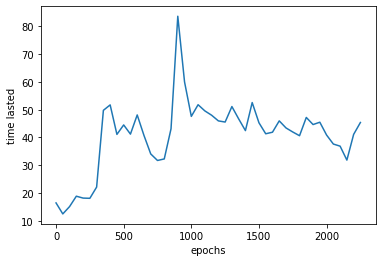

In [42]:
import matplotlib.pyplot as plt

plt.figure()
# xs = [i for i in range(1, 1431)]
avgs = []
num_avgs = []
for i in range(0, len(time_lasted), 50):
  avgs.append(np.average(time_lasted[i:i+50]))
  num_avgs.append(i)
plt.plot(num_avgs, avgs)
plt.xlabel("epochs")
plt.ylabel("time lasted")
plt.show()